How to use the Parking Tracker?

In [1]:
from PKLotDetector import PKLotDetector
# PKLotDetector is torch convolution neural network contains 3 convolution and 2 fully-connected layers, it is binary classificator

from ParkingTracker import ParkingTracker
# Parking Tracker is the class that makes all the process, its convitient usage of BoundingBoxDrawer and PKLotDetector

import pickle
import torch
import cv2
from PIL import Image
from torchvision import transforms as tt

firstly open usage example -> bounding boxes creation

In [2]:
# To create parking tracker we need bounding boxes, PKLotDetector and transforms, so lets create it firstly

# annotate bounding boxes, but just for 1 image because camera is static.
# load bounding boxes
bounding_boxes_path = 'Usage Example/bounding_boxes.pkl'

with open(bounding_boxes_path, 'rb') as f:
    bounding_boxes = pickle.load(f)

# Load the Neural Network weights
weights_path = "pklot_detector.pth"
pklot_detector = PKLotDetector()
pklot_detector.load_state_dict(torch.load(weights_path))

# transforms
transforms = tt.Resize((100, 100))

In [3]:
# Create the parking tracker
parking_tracker = ParkingTracker(pklot_detector, bounding_boxes, transforms)

In [4]:
def to_torch(numpy_image):
    numpy_image = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB) / 255
    return torch.from_numpy(numpy_image).permute(2, 0, 1).float()


def to_uint8(torch_image):
    torch_image *= 255
    return torch_image.to(torch.uint8)


def to_numpy(torch_image, bgr):
    torch_image = torch_image.permute(1, 2, 0).numpy()
    torch_image = cv2.cvtColor(torch_image, cv2.COLOR_BGR2RGB) if bgr else torch_image
    return torch_image

----
For image detect

/Users/osiprovin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


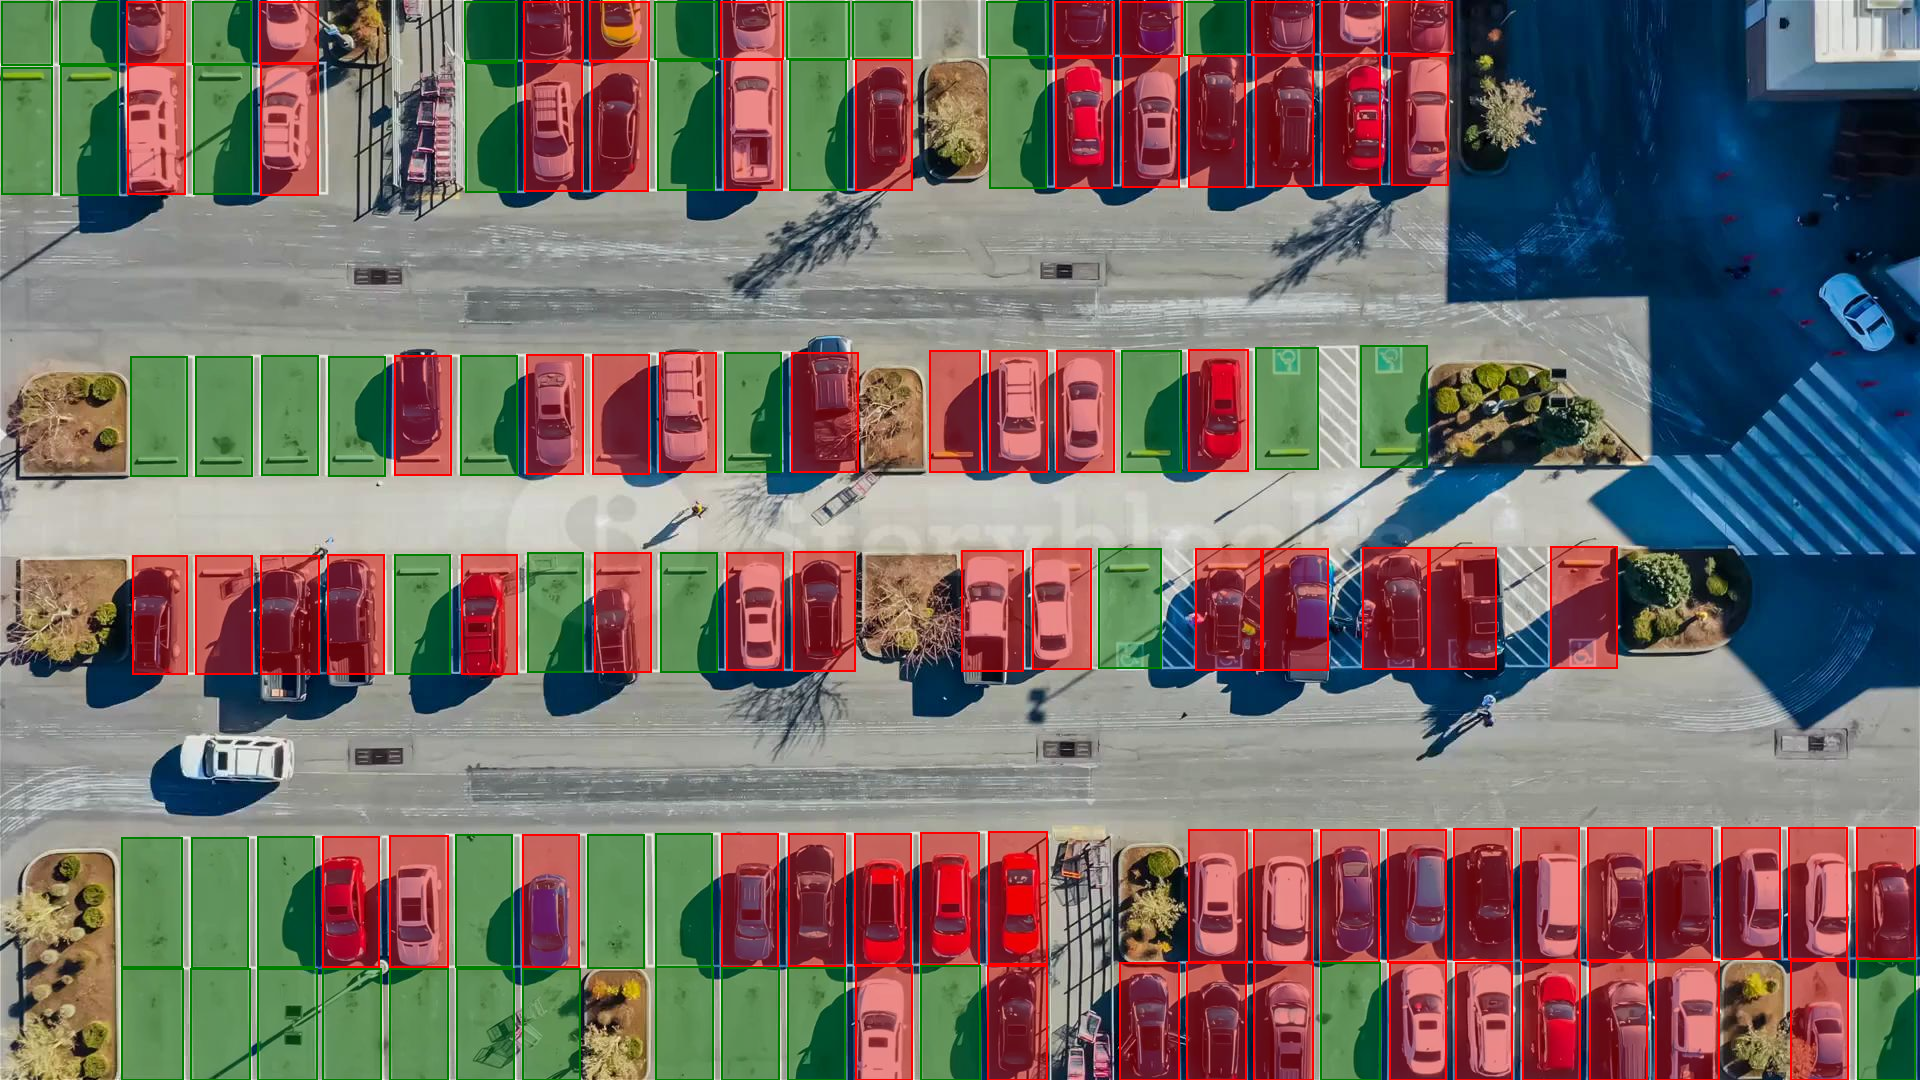

In [5]:
# open the parking image
image_path = "/Users/osiprovin/Desktop/ml:dl/CV/Parking detection/Usage Example/image_to_annotate.jpg"
image = cv2.imread(image_path)

# crop image by bounding boxes
torch_image = to_torch(image)
cropped_images = parking_tracker.crop_image(torch_image)

# get predicts
predicts = parking_tracker.detect(cropped_images)

# draw bounding boxes 
uint_image = to_uint8(torch_image)
drawed_image = parking_tracker.draw_bounding_boxes(uint_image, predicts)

# show image
output_image = to_numpy(drawed_image, bgr=False)
Image.fromarray(output_image)

In [6]:
video_source = "/Users/osiprovin/Desktop/ml:dl/CV/Parking detection/Usage Example/parking_video.mp4"

cap = cv2.VideoCapture(video_source)
frame_rate = cap.get(cv2.CAP_PROP_FPS)

interval = 0.1
interval_frames = int(frame_rate * interval)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_video_path = '/Users/osiprovin/Desktop/ml:dl/CV/Parking detection/Usage Example/output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'avc1')  
out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (frame_width, frame_height))

frame_count = 0




while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    torch_image = to_torch(frame)


    if frame_count % interval_frames == 0:
        cropped_images = parking_tracker.crop_image(torch_image)
        predicts = parking_tracker.detect(cropped_images)


    torch_image = to_uint8(torch_image)
    drawed_image = parking_tracker.draw_bounding_boxes(torch_image, predicts)
    output_image = to_numpy(drawed_image, bgr=True)



    cv2.imshow('Parking Tracker', output_image)
    out.write(output_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


    frame_count += 1



cap.release()
out.release()
cv2.destroyAllWindows()